In [3]:
from math import ceil
import numpy as np
from numpy.lib.function_base import percentile
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pickle

## Pre-processing data 

In [4]:
def hypergeometricparams(df, voc):
    
    # given the dataframe df and a particular variant of concern voc
    # returns a list of triples (delay, N, K), where
    # delay is the day since first detection of the variant of concern
    # N is the total number of sequences from that day
    # K is the total number of sequences from that variant of concern in that day

    #week = lambda day : day//7 #for coarse graining time
    #df['date']=df['date'].apply(week) #use this if temporal coarse-graining

    #simplify dataframe to simply (date, samples)
    df = df.groupby('date')['variant'].apply(list).reset_index(name='variant')
    
    #day of first detection is set to zero initially, and we create a list of parameters for
    #the hypergeometric distributions associated to each temporal bin
    dayoffirstdetection = -1
    hypergeometricdists = []

    for index, row in df.iterrows(): #iterating over time bins
        K = row['variant'].count(voc) #number of variants of concern sequenced in time bin
        N = len(row['variant']) #total number of sequences in time bin
        # now we drop all data points before the variant is first detected
        # from the day of first detection onward, we create a list with dates and some parameters of the
        # hypergeometric distribution associated to that date

        if (dayoffirstdetection == -1): 
            if K:                      
                dayoffirstdetection = row['date']
                hypergeometricdists.append((0,N,K))
            else:
                df = df.drop([index])
        else: 
            hypergeometricdists.append((row['date']-dayoffirstdetection,N,K))

    final_df = pd.DataFrame(hypergeometricdists, columns = ['delay', 'N', 'K'])
    return final_df

## Homogeneuous sub-sampling

In [5]:
def generate_pickle_subsampling(country,voc_list,name_to_save,Nit):
    
    #Algorithm for subsampling for each rate and saving in pickle.
    #For each voc and each rate (p value) of homogeneous subsampling, it calls the function subsamplestsimulation
    #and returns the mean, the 2.5% and 97.5% percentils and the std of delays for each rate
    #Saves all the vocs and rates in a dict and save this dict in the pickle
    
    
    USA_ratio = 589820/33498545
    ENG_ratio = 347970/4605805
    BR_ratio = 20788/17628588
    
    if country == 'en':
        COUNTRY_ratio = ENG_ratio
    elif country == 'usa':
        COUNTRY_ratio = USA_ratio
    
    plot_dict = {}
    
    for voc in voc_list:

        df = pd.read_table("/home/renata/Desktop/gabriela_group/final/dataset_metadata_{0}.csv".format(country),sep=',') #data

        x = hypergeometricparams(df, voc)

        means = []
        stds = []
        s_list = []
        devs_l = []
        devs_u = []

        for p in range(5,100,5):
                
            s = p/100 #subsampling rate
            s_list.append(s)
            #Nit = 1000 #number of rounds of subsampling
            mean, lower, upper,std = subsamplesimulation(x, s, Nit)
            means.append(mean)
            stds.append(std)
            devs_l.append(lower)
            devs_u.append(upper)
            #print(mean,lower,upper)
        
        for p in range(19):
            s = 0.005 + 0.005*p
            s_list.append(s)
            #Nit = 1000 #number of rounds of subsampling
            mean, lower, upper,std = subsamplesimulation(x, s, Nit)
            means.append(mean)
            stds.append(std)
            devs_l.append(lower)
            devs_u.append(upper)
            #print(mean,lower,upper)
            
        for s in [0.001,BR_ratio/COUNTRY_ratio]:
            s_list.append(s)
            #Nit = 1000 #number of rounds of subsampling
            mean, lower, upper,std = subsamplesimulation(x, s, Nit)
            means.append(mean)
            stds.append(std)
            devs_l.append(lower)
            devs_u.append(upper)
            #print(mean,lower,upper)

        plot_dict[voc] = [s_list,means,devs_l,devs_u,stds]
        print ("Finished variant {0}".format(voc))
    
    #saves plot_dict in a pickle file that can be used to plot the data later (without having to do the simulation again)
    with open("/home/renata/Desktop/gabriela_group/final/subsampling_rate_plot_dict_{0}_{1}".format(country,name_to_save), 'wb') as handle:
            pickle.dump(plot_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print("Finished generating pickle files")


def subsamplesimulation(df, p, Nit):
    # given a dataframe df, the rate of subsampling p and number of subsampling iterations Nit
    # return mean and standard deviation of delay of first detection
    
    delays = [] #list of observed delays for each sampling round
    
    for i in range(Nit):
        for index, row in df.iterrows(): #iterate over dates
            if subsampletest(row, p): #test to see if any voc is caught in the subsampling of that date
                delays.append(row['delay'])
                break
    
    #return delays # full data of the simulation
    return np.average(delays), np.percentile(delays,2.5), np.percentile(delays,97.5), np.std(delays)
    #return np.average(delays), np.std(delays)

def subsampletest(dfrow, p, Nsamplerandom = False):
    # given a row from a dataframe = (delay, N, K) and rate of subsampling p
    # randomly samples a Hypergeometric(N, K, p * N) and returns
    # True if the sample contains one of the K marked items
    # False otherwise
    N = dfrow['N'] # total sequence count
    K = dfrow['K'] # voc sequence count
    # now we need to define the number of samples to be taken
    # the problem is that if N is small the rounding error can seriously affect the test
    # this is what the Nsamplerandom option modulates. If it's True then we randomly
    # round the integer p*N up by a rejection test against p.
    # TODO: find an actual solution to this problem
    Nsample = int(p*N)
    if Nsamplerandom:
        if np.random.rand() < p:
            Nsample += 1

    if Nsample:
        # np.random.hypergeometric(N - K, K, Nsample) returns the number of non-voc samples
        # obtaining in a sampling of the distribution above. Thus, the voc is detect
        # if and only if that number is less than Nsample
        return np.random.hypergeometric(N - K, K, Nsample) < Nsample
    return False


## Functions to plot

In [6]:
def plot_relative_freq_day(voc_list,country):
    
    #plot relative frequence for each variant 
    
    plt.figure()
    plot_dict = {}

    for voc in voc_list:

        df = pd.read_table("/home/renata/Desktop/gabriela_group/final/dataset_metadata_{0}.csv".format(country),sep=',') #data

        x = hypergeometricparams(df, voc)

        plot_dict[voc] = x
    
    fig, ((ax1, ax2), (ax3,ax4))= plt.subplots(2, 2,constrained_layout=True)
    
    if country == 'en':
        ax1.axis('off')
    else:
        voc = 'alpha'
        ax1.plot(plot_dict[voc]['delay'],plot_dict[voc]['K']/plot_dict[voc]['N'])
        ax1.set_title(voc)
    
    voc = 'beta'
    ax2.plot(plot_dict[voc]['delay'],plot_dict[voc]['K']/plot_dict[voc]['N'])
    ax2.set_title(voc)
    
    voc = 'gamma'
    ax3.plot(plot_dict[voc]['delay'],plot_dict[voc]['K']/plot_dict[voc]['N'])
    ax3.set_title(voc)
    
    voc = 'delta'
    ax4.plot(plot_dict[voc]['delay'],plot_dict[voc]['K']/plot_dict[voc]['N'])
    ax4.set_title(voc)
    
    
    
    text1 = fig.text(0.5, 1.04, '{0} - Frequence of each VOC '.format(country), ha='center', fontsize=16)
    text3 = fig.text(0.5, -0.07, 'Days since first detection', ha='center', fontsize=16)
    text2 = fig.text(-0.04, 0.5, ' VOC/total sequencing', va='center', rotation='vertical', fontsize=16)

    plt.savefig("/home/renata/Desktop/gabriela_group/final/relative_freq_day{0}.png".format(country),transparent = False,dpi = 200, bbox_inches = 'tight',facecolor = 'white')

    

def plot_subsampling_rate(country,YLIM,XUPP, name_to_save,SHAREY = True):
    
    #Plot subsampling 
    
    #Ratio -> Seq_cases/Acc_cases
    USA_ratio = 589820/33498545
    ENG_ratio = 347970/4605805
    BR_ratio = 20788/17628588
    
    pickle_loc = "/home/renata/Desktop/gabriela_group/final/subsampling_rate_plot_dict_{0}_{1}".format(country,name_to_save)

    with open(pickle_loc, 'rb') as handle:
        plot_dict = pickle.load(handle)
        
    plt.figure(figsize = (10,5))
    
    if country == 'en':
        vline = BR_ratio/ENG_ratio
        vline2 = USA_ratio/ENG_ratio
        vline_legend = 'BR relative seq'
        vline2legend = 'USA relative seq'
        
        fig, ((ax1, ax2), (ax3,ax4))= plt.subplots(2, 2,constrained_layout=True,
                          sharex=True, sharey=SHAREY)
        
        XINF = 0

        voc = 'beta'
        ax1.errorbar(plot_dict[voc][0], plot_dict[voc][1], yerr=[plot_dict[voc][2],plot_dict[voc][3]],capsize=4, fmt="o",markersize=2)
        ax1.set_title('Beta')
        ax1.set_ylim(-10,YLIM)
        ax1.set_xlim(XINF,XUPP)
        ax1.vlines(vline,-10,YLIM,'red',label = vline_legend)


        voc = 'gamma'
        ax2.errorbar(plot_dict[voc][0], plot_dict[voc][1], yerr=[plot_dict[voc][2],plot_dict[voc][3]],capsize=4, fmt="o",markersize=2)
        ax2.set_title('Gamma')
        ax2.set_ylim(-10,YLIM)
        ax2.set_xlim(XINF,XUPP)
        ax2.vlines(vline,-10,YLIM,'red',label = vline_legend)

        voc = 'delta'
        ax3.errorbar(plot_dict[voc][0], plot_dict[voc][1], yerr=[plot_dict[voc][2],plot_dict[voc][3]],capsize=4, fmt="o",markersize=2)
        ax3.set_title('Delta')
        ax3.set_ylim(-10,YLIM,'red')
        ax3.set_xlim(XINF,XUPP)
        ax3.vlines(vline,-10,YLIM,'red',label = vline_legend)
        
        ax4.axis('off')
        
        

    elif country == 'usa':
        vline = BR_ratio/USA_ratio
        vline2 = ENG_ratio/USA_ratio
        vline_legend = 'BR relative seq'
        
        fig, ((ax1, ax2), (ax3,ax4))= plt.subplots(2, 2,constrained_layout=True,
                          sharex=True, sharey=SHAREY)
        
        XINF = 0
        voc = 'alpha'
        ax1.errorbar(plot_dict[voc][0], plot_dict[voc][1], yerr=[plot_dict[voc][2],plot_dict[voc][3]],capsize=4, fmt="o",markersize=2,label='{0}'.format(voc))
        ax1.set_title('Alpha')
        ax1.set_ylim(-10,YLIM)
        ax1.set_xlim(XINF,XUPP)
        ax1.vlines(vline,-10,YLIM,'red',label = vline_legend)

        voc = 'beta'
        ax2.errorbar(plot_dict[voc][0], plot_dict[voc][1], yerr=[plot_dict[voc][2],plot_dict[voc][3]],capsize=4, fmt="o",markersize=2)
        ax2.set_title('Beta')
        ax2.set_ylim(-10,YLIM)
        ax2.set_xlim(XINF,XUPP)
        ax2.vlines(vline,-10,YLIM,'red',label = vline_legend)


        voc = 'gamma'
        ax3.errorbar(plot_dict[voc][0], plot_dict[voc][1], yerr=[plot_dict[voc][2],plot_dict[voc][3]],capsize=4, fmt="o",markersize=2)
        ax3.set_title('Gamma')
        ax3.set_ylim(-10,YLIM)
        ax3.set_xlim(XINF,XUPP)
        ax3.vlines(vline,-10,YLIM,'red',label = vline_legend)


        voc = 'delta'
        ax4.errorbar(plot_dict[voc][0], plot_dict[voc][1], yerr=[plot_dict[voc][2],plot_dict[voc][3]],capsize=4, fmt="o",markersize=2)
        ax4.set_title('Delta')
        ax4.set_ylim(-10,YLIM,'red')
        ax4.set_xlim(XINF,XUPP)
        ax4.vlines(vline,-10,YLIM,'red',label = vline_legend)

       
    
    if country == 'en':
        ax2.vlines(vline2,-10,YLIM,'green',label = vline2legend)
        ax1.vlines(vline2,-10,YLIM,'green')
        ax3.vlines(vline2,-10,YLIM,'green')
        ax2.legend()
    
    else:
        ax3.legend(loc='upper right')
        ax4.legend(loc='upper right')


    text1 = fig.text(0.5, -0.06, 'Subsampling rate', ha='center', fontsize=16)
    text2 = fig.text(-0.04, 0.5, 'Delays from first detection (days)', va='center', rotation='vertical', fontsize=16)
    text3 = fig.text(0.5, 1.04, '{0} subsampling'.format(country), ha='center', fontsize=16)
    #plt.legend(bbox_to_anchor=(1.05, 1), )
    
    plt.savefig("/home/renata/Desktop/gabriela_group/final/subsampling_rate_{0}_{1}_{2}.png".format(country,name_to_save,XUPP),dpi = 200, transparent = False,bbox_inches = 'tight',facecolor = 'white')


<Figure size 432x288 with 0 Axes>

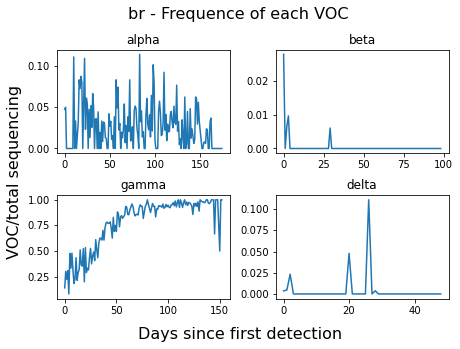

In [7]:
#Plot Relative sequencing Number per day - VOC/TOTAL
voc_list = ['alpha','beta','delta','gamma']
country = 'br' # br, usa
plot_relative_freq_day(voc_list,country)

In [8]:
#Generating the data of homogeneuous subsampling for the variants
country = 'en' #usa, en

if country == 'usa':
    voc_list = ['alpha','beta','delta','gamma']
elif country == 'en':
    voc_list = ['beta','delta','gamma']
    
name_to_save = '0.5to10_5to100'
Nit = 1000
#generate_pickle_subsampling(country,voc_list,name_to_save,Nit)

<Figure size 720x360 with 0 Axes>

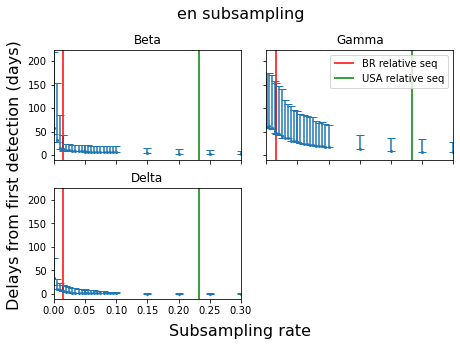

In [14]:
#Plot using the picke file (you do not have to run the subsampling algorithm again)
YLIM = 225 #usa:150 and en:225 
name_to_save = '0.5to10_5to100' 
country = 'en' 
XUPP = 0.3
plot_subsampling_rate(country,YLIM,XUPP,name_to_save,SHAREY = True)

## Table of results comparing VOCs in the BR rate

In [20]:
def plot_table(country):
    
    pickle_loc = "/home/renata/Desktop/gabriela_group/subsampling_rate_plot_dict_{0}_{1}".format(country,name_to_save)
    
    USA_ratio = 589820/33498545
    ENG_ratio = 347970/4605805
    BR_ratio = 20788/17628588
    
    if country == 'en':
        COUNTRY_ratio = ENG_ratio
    elif country == 'usa':
        COUNTRY_ratio = USA_ratio
    
    
    with open(pickle_loc, 'rb') as handle:
        plot_dict = pickle.load(handle)

    df_table = {}
    index_list = []
    for voc in plot_dict:
        if voc == 'alpha' and country == 'en':
            pass
        else:
            index_list.append(voc)
            
            for rate in [BR_ratio/COUNTRY_ratio]:
            #for rate in [0.1, 0.07500000000000001, 0.05, 0.01,0.005,0.001,BR_ratio/COUNTRY_ratio]:
                index = plot_dict[voc][0].index(rate)

                mean = plot_dict[voc][1][index]
                std = plot_dict[voc][4][index]

                if mean < 1:
                    ROUNDMEAN = 2
                    ROUNDSTD = 2
                elif mean < 10:
                    ROUNDMEAN = 1
                    ROUNDSTD = 1
                else:
                    ROUNDMEAN = None
                    ROUNDSTD = None

                mean = round(mean,ROUNDMEAN)
                std = round(std,ROUNDSTD)

                if rate == 0.07500000000000001:
                    rate = 0.075
                
                if rate == BR_ratio/COUNTRY_ratio:
                    rate = 'BR ratio ({0}%)'.format(round((BR_ratio/COUNTRY_ratio)*100,2))
                else:
                    rate = '{0}%'.format(rate*100)
                
                if rate in df_table.keys():
                    df_table[rate].append('{0}({1})'.format(mean,std))
                else:
                    df_table[rate] = ['{0}({1})'.format(mean,std)]

    df_table = pd.DataFrame.from_dict(df_table)
    df_table.index = index_list
    
    return df_table

In [21]:
country = 'usa'
df_table = plot_table(country)

In [22]:
print('Delays in detection -',country,'subsampling')
df_table

Delays in detection - usa subsampling


,BR ratio (6.7%)
alpha,3.1(2.9)
beta,7.0(9.6)
delta,1.9(1.8)
gamma,21(14)
